# P3G Dataset


In [ ]:
# Load data
import pandas as pd
from datetime import timedelta
import io
from google.colab import files
# Manipulation and visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import itertools
import matplotlib.colors as mcolors

In [ ]:
#from google.colab import files

uploaded = files.upload()

Saving p1e_dataset.csv to p1e_dataset.csv


Creamos los dataframes para p3g. Aquí se crea un solo dataframe cuyo índice es la fecha, lo cual es útil para cargar las series temprales como series de Panda con índice temporal.

In [ ]:
# Cargamos los DataFrames
p1e_df = pd.read_csv(io.BytesIO(uploaded['p1e_dataset.csv']), index_col='Date',
                 parse_dates=True)

p1e_df

,p1ex_position,p1ey_position,p1ex_width,p1ey_width
Date,,,,
2019-11-28,-0.6446,0.2463,1.5640,1.2233
2019-11-29,-0.7316,0.2272,1.5857,1.2265
2019-12-03,-0.7645,0.1863,1.5828,1.2450
2019-12-05,-0.7783,0.1635,-0.7783,1.2506
2019-12-11,-0.7778,0.2534,1.5862,1.2407
...,...,...,...,...
2023-11-29,-1.1781,-0.0934,1.0779,1.1180
2023-11-30,-1.1796,-0.0824,1.0755,1.1159
2023-12-01,-1.1902,-0.0745,1.0679,1.1152


Ahora graficamos las series temprales para p3g.

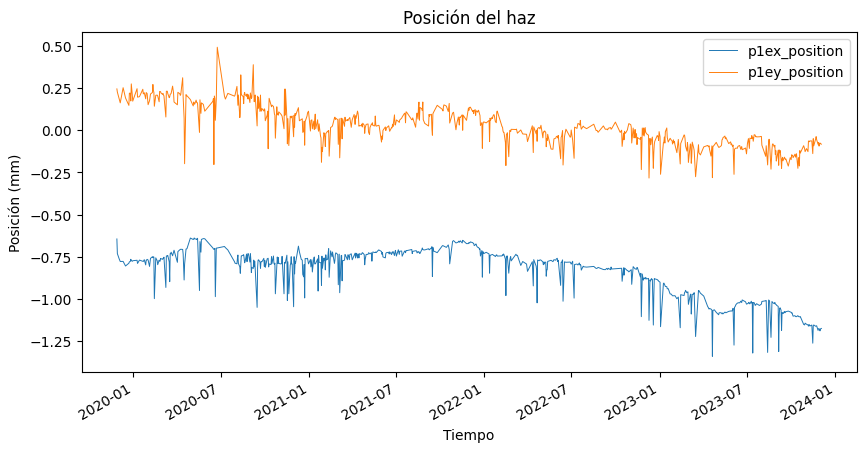

In [ ]:
# Creamos las series temporales
#ts_p3gx = pd.DataFrame(p3g_df, columns=['Date','p3gx']).set_index('Date')
#ts_p3gy = pd.DataFrame(p3g_df, columns=['Date','p3gy']).set_index('Date')
#ts_p3gx_width = pd.DataFrame(p3g_df, columns=['Date','p3gx_width']).set_index('Date')
#ts_p3gy_width = pd.DataFrame(p3g_df, columns=['Date','p3gy_width']).set_index('Date')
#ts_p3g_current = pd.DataFrame(p3g_df, columns=['Date','p3g_current']).set_index('Date')

# to set the plot size
plt.figure(figsize=(10, 5))
p1e_df['p1ex_position'].plot(label='p1ex_position', linewidth=0.7)
p1e_df['p1ey_position'].plot(label='p1ey_position', linewidth=0.7)

# adding title to the plot
plt.title('Posición del haz')

# adding Label to the x-axis
plt.xlabel('Tiempo')
plt.ylabel('Posición (mm)')

# adding legend to the curve
plt.legend()

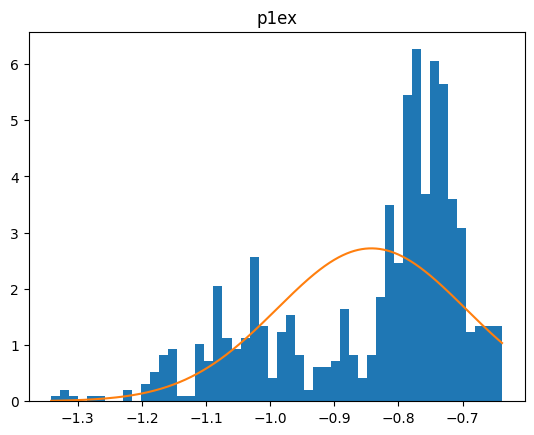

In [ ]:
from scipy import stats
from scipy.stats import norm

# Initialise the subplot function using number of rows and columns
figure, ax = plt.subplots()

#ax = p1e_df['p1ey'].plot.hist(bins=50,density=True)
funct = p1e_df['p1ex_position']

ax.hist(funct, bins=50,density=True)
ax.set_title('p1ex')
mean, std = norm.fit(funct)
x=np.linspace(funct.min(),funct.max(),1000)
pdf=norm.pdf(x,mean,std)
ax.plot(x,pdf)

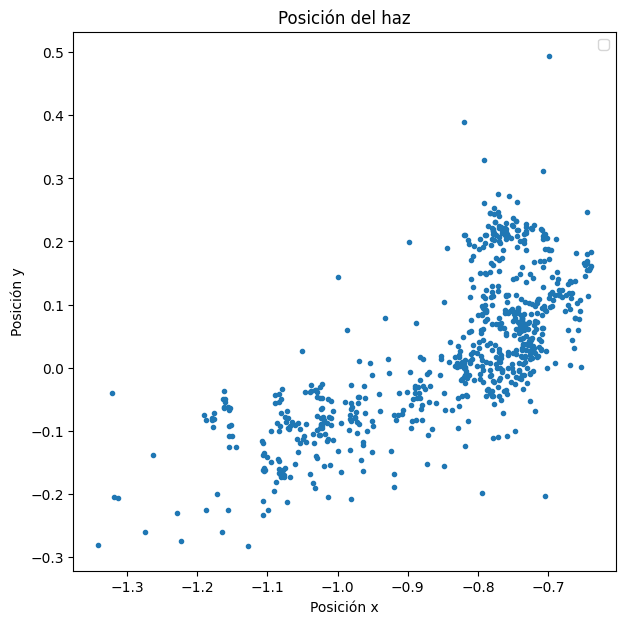

In [ ]:
%matplotlib inline

plt.figure(figsize=(7, 7))
plt.scatter(p1e_df['p1ex_position'], p1e_df['p1ey_position'], marker='.')
# adding title to the plot
plt.title('Posición del haz')

# adding Label to the x-axis
plt.xlabel('Posición x')

# adding Label to the y-axis
plt.ylabel('Posición y')

# adding legend to the curve
plt.legend()
plt.show()

Estas series tienen missing values así que se podria utilizar la interpolación de Holt para series irregulares.

In [ ]:
def mapping_idx(seriesA, seriesB):
  """ Esta funcion requiere dos series como parametros y retorna una serie cuyos
  indices estan mapeados de la serie A a la serie B para aquellos elementos que
  son iguales en las series
  """

  # Create a mapping between elements in series A and their indexes
  index_mapping = {element: idx for idx, element in seriesA.items()}

  # Assign indexes from seriesA to seriesB when elements match
  mapped_indexes = [index_mapping[element] if element in index_mapping else pd.NA for element in seriesB]

  # Assign the mapped indexes to a new column in seriesB
  seriesB_mapped = seriesB.copy()
  seriesB_mapped.index = mapped_indexes
  return seriesB_mapped

In [ ]:
# Restamos el ultimo y primer elemento de la serie
delta = p1e_df.index[-1] - p1e_df.index[0]

# El timedelta resultante se transforma a minutos
total_days = delta.days
series_elements = total_days

import datetime

start_timestamp = datetime.datetime(2019, 11, 28)  # Specify the starting timestamp
num_entries = 1 + series_elements  # Number of timestamps to generate

timestamps = []


for i in range(int(num_entries)):
    timestamp = start_timestamp + datetime.timedelta(days=i)
    timestamps.append(timestamp)

# Vamos a estimar el tamano de la serie sin missing values
full_timestep_series = pd.Series(timestamps)

missing_timestep_series = p1e_df.index.to_series()

newcolumn = mapping_idx(full_timestep_series, missing_timestep_series)

#full_timestep_series.to_csv('output.csv', encoding = 'utf-8-sig')
#files.download('output.csv')

# Creo un nuevo dataframe df1 con el mapeo correcto de los indices
#newp1e_df= pd.DataFrame({'Date': newcolumn, 'p1ex': p1e_df['p1ex'].tolist(),
#                       'p1ey': p1e_df['p1ey'].tolist(), 'p1ex_width': p1e_df['p1ex_width'].tolist(),
#                         'p1ey_width': p1e_df['p1ey_width'].tolist()})

newp1e_df= pd.DataFrame({'Date': newcolumn, 'p1ex_position': p1e_df['p1ex_position'].tolist(),
                       'p1ey_position': p1e_df['p1ey_position'].tolist()})

# Se crea un nuevo dataframe con los missing values
# Define the desired index range
desired_index = range(newp1e_df.index.min(), newp1e_df.index.max() + 1)

# Reindex the DataFrame with the desired index range and fill missing elements with np.nan
result_p1e_df = newp1e_df.reindex(desired_index).fillna(np.nan)

# Asigno full_timestep_series como el nuevo indice del dataframe
result_p1e_df.set_index(full_timestep_series, inplace=True)

# Remuevo la columna Date
result_p1e_df.drop('Date', axis=1, inplace=True)
result_p1e_df


,p1ex_position,p1ey_position
2019-11-28,-0.6446,0.2463
2019-11-29,-0.7316,0.2272
2019-11-30,NaN,NaN
2019-12-01,NaN,NaN
2019-12-02,NaN,NaN
...,...,...
2023-11-30,-1.1796,-0.0824
2023-12-01,-1.1902,-0.0745
2023-12-02,-1.1785,-0.0793
2023-12-03,NaN,NaN


Graficamos las series para p3gx y p3gy con missing values como NaN

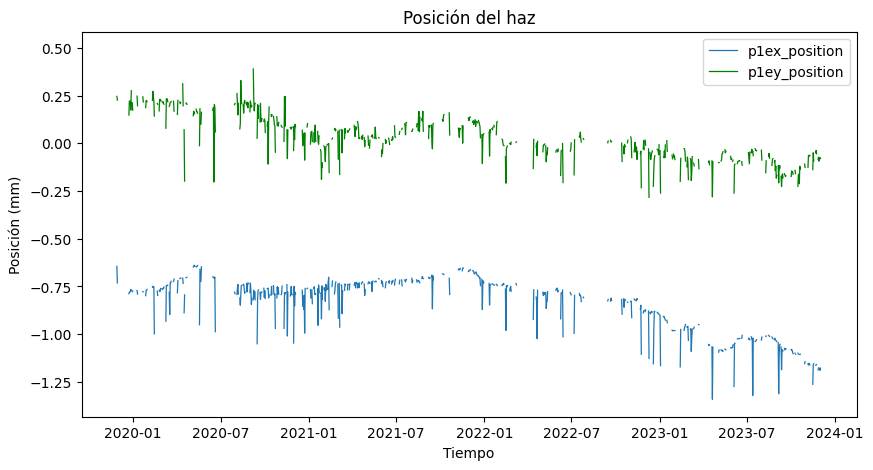

In [ ]:
# to set the plot size

plt.figure(figsize=(10, 5))
#result_p3g_df['p3gx'].plot(label='p3gx', linewidth=0.7)
#result_p3g_df['p3gy'].plot(label='p3gy', linewidth=0.7)

plt.plot(result_p1e_df['p1ex_position'], label='p1ex_position', linewidth=0.9)
plt.plot(result_p1e_df['p1ey_position'], label='p1ey_position', color='green', linewidth=0.9)

# adding title to the plot
plt.title('Posición del haz')

# adding Label to the x-axis
plt.xlabel('Tiempo')
plt.ylabel('Posición (mm)')

# adding legend to the curve
plt.legend()

In [ ]:
# importing libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

z = np.arange(len(result_p1e_df))

fig = go.Figure(data=[go.Scatter3d(
    x=result_p1e_df['p1ex_position'],
    y=result_p1e_df['p1ey_position'],
    z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,                # set color to an array/list of desired values
        colorscale='viridis',   # choose a colorscale
        opacity=0.8,
        colorbar=dict(thickness=15)
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

# Add a color bar which maps values to colors.

fig.show()

## Ahora vamos a utilizar la interpolacion de Holt

coefficient of determination: 0.04388033757216614
intercept: 0.19961059113300494
slope: [0.00080113]


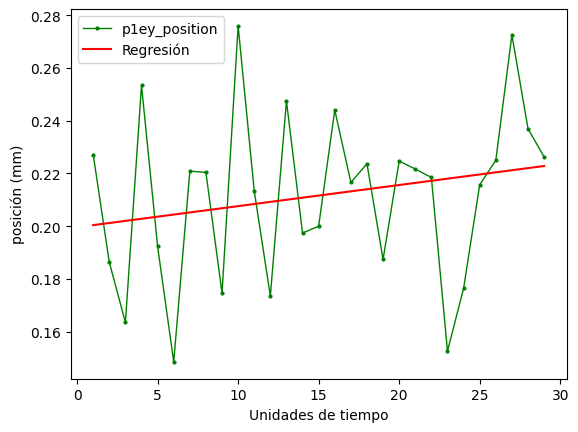

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

# extraigo los 100 primeros elementos de la serie para ajustarlos con
# una regresion lineal
step = 1
inicial = 1
final = 30
x = pd.Series(range(inicial, final, step)).to_numpy().reshape(-1, 1)
y = p1e_df['p1ey_position'].iloc[inicial:final].to_numpy()

model = LinearRegression().fit(x, y)

r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

plt.plot(x, y, 'go-', linewidth=1, markersize=2, label='p1ey_position')
plt.plot(x, model.predict(x), color='red', label='Regresión')
plt.ylabel("posición (mm)")
plt.xlabel("Unidades de tiempo")
plt.legend()
plt.show()

In [ ]:
# Funcion de interpolacion

A = model.intercept_
B = model.coef_
q = 1
L0 = A
M0 = B


def holt_interpolation(a, c, timesteps, Xn):

  # aseguro que todos los timesteps inicien desde cero para cualquier parte de
  # la series que se analice
  index = [i for i in range(len(timesteps))] # creo el indice de la serie
  timesteps = pd.Series(index) # le asigno a la serie de tiempo valores 0, 1, 2...
  timesteps.index = index # cambio el indice de la serie a 0, 1, 2...
  Xn.index = index # le asigno a la serie de datos indices desde 0, 1, 2...

  # Rellena los valores NaN de los datos de entrada con ceros
  Xn = Xn.fillna(0)

  U0 = 1 - (1 - c)**q
  V0 = 1 - (1 - a)**q

  # Calculo de parametro Vn
  Vn = np.zeros(len(timesteps))

  for step in timesteps:
    if step == 0:
      Vn[0] = V0
    else:
      step = int(step)
      Vn[step] = Vn[step - 1] / (((1 - a)**(step - (step - 1))) + Vn[step - 1])

  # Calculo de parametro Un
  Un = np.zeros(len(timesteps))

  for step in timesteps:
    if step == 0:
      Un[0] = U0
    else:
      step = int(step)
      Un[step] = Un[step - 1] / (((1 - c)**(step - (step - 1))) + Un[step - 1])

  # Inicializacion de arrays para Ln y Mn
  Ln = np.zeros(len(timesteps))
  Mn = np.zeros(len(timesteps))
  Fn = np.zeros(len(timesteps))

  for step in timesteps:
    if step == (len(timesteps)-1): # to avoid index error
      break
    if step == 0:
      Mn[0] = M0
      Ln[0] = L0
      Fn[step] = Xn[step]
      Fn[step + 1] = L0 - M0*(step - (step - 1))

    else:
      step = int(step)
      if Xn[step] == 0:
        Xn[step] =  Xn[step-1]
        Ln[step] = (1 - Vn[step])*(Ln[step - 1] + (step - (step - 1))*Mn[step - 1]) + Vn[step]*Xn[step]
        Mn[step] = (1 - Un[step])*Mn[step - 1] + (Un[step]*(Ln[step] - Ln[step - 1])) / (step - (step - 1))
        Fn[step + 1] = Ln[step] + Mn[step]*(step - (step - 1))
      else:
        #Fn[step + 1] = Xn[step-1]
        Ln[step] = (1 - Vn[step])*(Ln[step - 1] + (step - (step - 1))*Mn[step - 1]) + Vn[step]*Xn[step]
        Mn[step] = (1 - Un[step])*Mn[step - 1] + (Un[step]*(Ln[step] - Ln[step - 1])) / (step - (step - 1))
        Fn[step + 1] = Ln[step] + Mn[step]*(step - (step - 1))


  return Fn

Estimacion de los parametros del agoritmo de interpolacion

In [ ]:
# Ahora rellenamos la serie con ceros para poder utilizarla en el algoritmo
# extendido de Holt

output_data = result_p1e_df['p1ey_position'].fillna(0) # se llenan con ceros para reemplazar los missing values np.nan

In [ ]:
# Create a Series with numbers from 0 to 1302
start = 0
end = len(output_data)
step = 1

timesteps = pd.Series(range(start, end, step))

In [ ]:
# Ejecutamos el alisado de Holt para ajustar los datos simulados con missing values

param1 = np.arange(0.1, 1, 0.1)
arrays_list = []
c = 0.1
for a in param1:
  arrays_list.append(holt_interpolation(a, c, timesteps, output_data))


combined_numpy_array = np.vstack(arrays_list)
column_names = [i for i in range(combined_numpy_array.shape[1])]

dframe = pd.DataFrame(combined_numpy_array, columns=column_names)
dframe_transposed = dframe.T
dframe_transposed[9] = output_data


from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

mse_list = []
mae_list = []
mape_list = []

for k in range(0,9):
  mse_list.append(mean_squared_error(output_data, dframe_transposed[k]))
  mae_list.append(mean_absolute_error(output_data, dframe_transposed[k]))
  mape_list.append(mean_absolute_percentage_error(output_data, dframe_transposed[k]))

print(f" Menor mse: {min(mse_list)} Indice: a{mse_list.index(min(mse_list))}")
print(f" Mayor mse: {max(mse_list)} Indice: a{mse_list.index(max(mse_list))}")
print(f" Menor mae: {min(mae_list)} Indice: a{mae_list.index(min(mae_list))}")
print(f" Mayor mae: {max(mae_list)} Indice: a{mae_list.index(max(mae_list))}")
print(f" Menor mape: {min(mape_list)} Indice: a{mape_list.index(min(mape_list))}")
print(f" Mayor mape: {max(mape_list)} Indice: a{mape_list.index(max(mape_list))}")

<ipython-input-21-11bc765e08ff>:54: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-21-11bc765e08ff>:57: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-21-11bc765e08ff>:54: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-21-11bc765e08ff>:57: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

 Menor mse: 0.011101585684437424 Indice: a0
 Mayor mse: 0.012674648078717082 Indice: a8
 Menor mae: 0.07349050827567473 Indice: a1
 Mayor mae: 0.0769818415934867 Indice: a8
 Menor mape: 236083889843994.94 Indice: a1
 Mayor mape: 247033592937889.9 Indice: a8


<ipython-input-21-11bc765e08ff>:54: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-21-11bc765e08ff>:57: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-21-11bc765e08ff>:54: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

<ipython-input-21-11bc765e08ff>:57: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this o

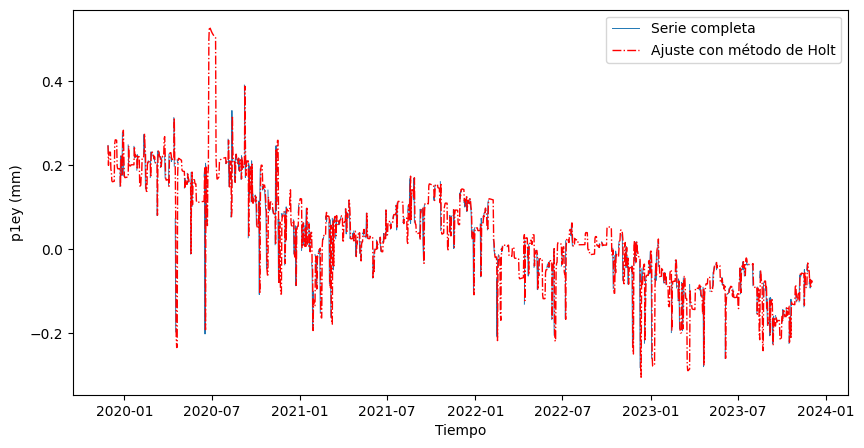

In [ ]:
# Ajuste de la serie con los parametros (a, c) optimos utilizando el
# metodo de Holt extendido en donde df_transposed[k] es el resultado del ajuste
# del alisado de Holt y k corresponde con el parametro "a" que minimiza las
# metricas

# Rellena los ceros de las series con np.nan para visualizacion
#Xn= Xn.replace(0, np.nan)
#df_transposed[8] = df_transposed[8].replace(0, np.nan)

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(result_p1e_df.index.to_numpy(), result_p1e_df['p1ey_position'], linewidth=0.7, label='Serie completa')
plt.plot(result_p1e_df.index.to_numpy(),dframe_transposed[8], 'r-.', linewidth=1, label='Ajuste con método de Holt')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Tiempo")
plt.ylabel("p1ey (mm)")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

(array([18262., 18444., 18628., 18809., 18993., 19174., 19358., 19539.,
        19723.]),
 [Text(18262.0, 0, '2020-01-01'),
  Text(18444.0, 0, '2020-07-01'),
  Text(18628.0, 0, '2021-01-01'),
  Text(18809.0, 0, '2021-07-01'),
  Text(18993.0, 0, '2022-01-01'),
  Text(19174.0, 0, '2022-07-01'),
  Text(19358.0, 0, '2023-01-01'),
  Text(19539.0, 0, '2023-07-01'),
  Text(19723.0, 0, '2024-01-01')])

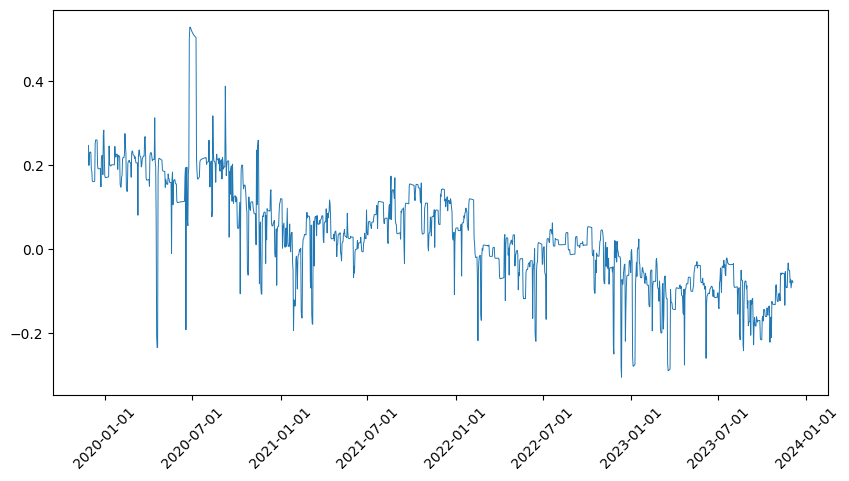

In [ ]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(result_p1e_df.index.to_numpy(), dframe_transposed[8],linewidth=0.7)

# Create a DateFormatter object to format the x-axis labels
date_format = mdates.DateFormatter('%Y-%m-%d')  # Format as 'YYYY-MM-DD'

# Apply the date format to the x-axis
ax.xaxis.set_major_formatter(date_format)

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)

In [ ]:
index_array = result_p1e_df.index.to_numpy()
data = dframe_transposed[8]

df = pd.DataFrame({'p1ey_position': data})
df.set_index(index_array, inplace=True)
df

,p1ey_position
2019-11-28,0.246300
2019-11-29,0.198809
2019-11-30,0.227733
2019-12-01,0.230417
2019-12-02,0.230396
...,...
2023-11-30,-0.093052
2023-12-01,-0.084236
2023-12-02,-0.075369
2023-12-03,-0.079156


In [ ]:
df.to_csv('p1ey_position.csv', index=True)
files.download('p1ey_position.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

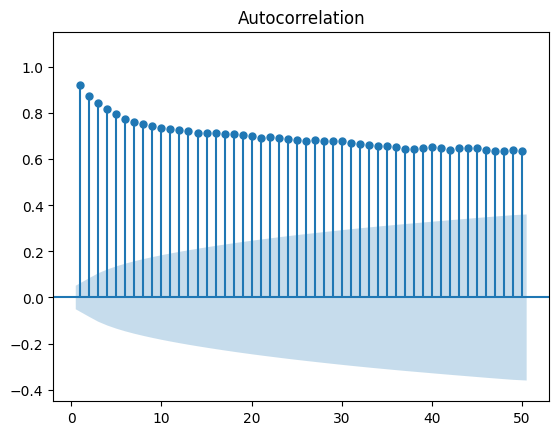

In [ ]:
# Now I will calculate the ccf for the trended white noise
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dframe_transposed[8], lags=50, zero=False, auto_ylims=True)
plt.show()

In [ ]:
p1ey_series = dframe_transposed[8]

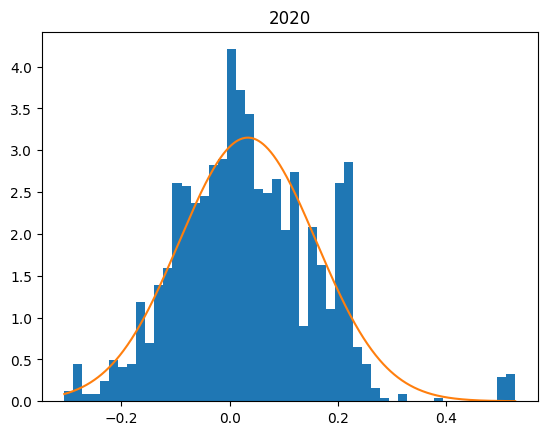

In [ ]:
from scipy import stats
from scipy.stats import norm


# Initialise the subplot function using number of rows and columns
figure, ax = plt.subplots()

#ax = p1e_df['p1ey'].plot.hist(bins=50,density=True)
funct = p1ey_series

ax.hist(funct, bins=50,density=True)
ax.set_title('2020')
mean, std = norm.fit(funct)
x=np.linspace(funct.min(),funct.max(),1000)
pdf=norm.pdf(x,mean,std)
ax.plot(x,pdf)


Text(0, 0.5, 'Valor')

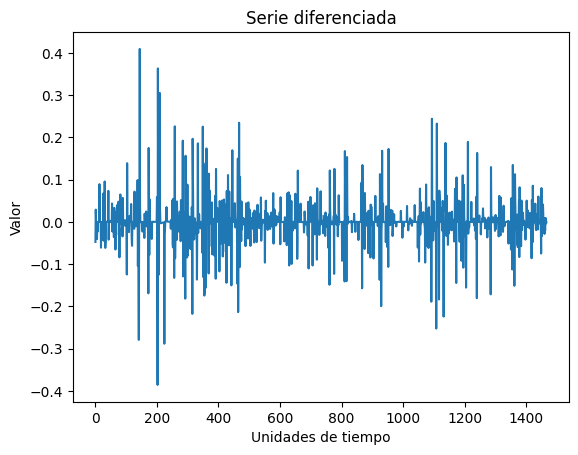

In [ ]:
diff_p1ex = np.diff(dframe_transposed[8], n=1)
plt.plot(diff_p1ex)
plt.xlabel("Unidades de tiempo")
plt.title('Serie diferenciada')
plt.ylabel("Valor")

Ahora vamos a aplicar el test de estacionaridad a la serie diferenciada para probar si el proceso es ahora estacionario

In [ ]:
#Probando estacionaridad con el estadistico ADF
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(diff_p1ex)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')
print(f'critical values: {ADF_result[4]}')

ADF Statistic: -12.318020012497295
p-value: 6.85127069248482e-23
critical values: {'1%': -3.434880391815318, '5%': -2.8635408625359315, '10%': -2.5678352438452814}


Se observa que el estadístico es más negativo que los valores críticos, por lo que podemos concluir que el proceso es ahora estacionario. Ahora veamos el resultado de la función de autocorrelación para este proceso.

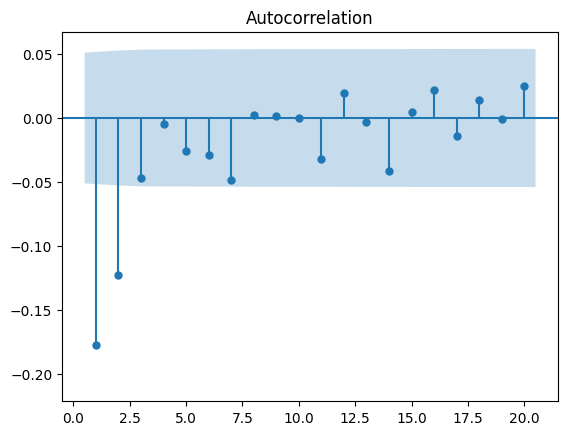

In [ ]:
with mpl.rc_context():
    mpl.rc("figure")  # here adjust the figure size
    plot_acf(diff_p1ex, lags=20, zero=False, auto_ylims=True)

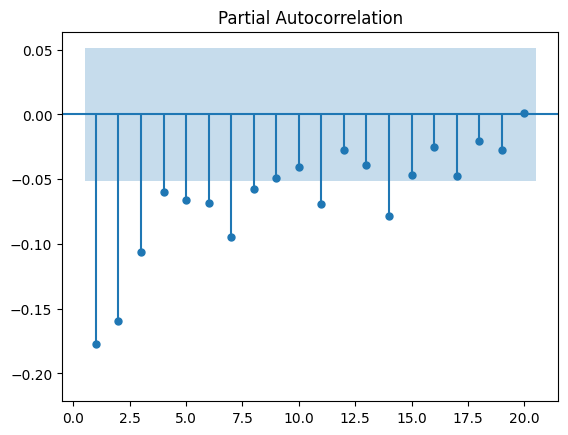

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
with mpl.rc_context():
    mpl.rc("figure")  # here adjust the figure size
    plot_pacf(diff_p1ex, lags=20, zero=False, auto_ylims=True)

Vamos a realizar predicciones utilizando rolling forecast. Creamos los conjuntos de entrenamiento y de prueba

In [ ]:
df_diff = pd.DataFrame({'diff_p1ex': diff_p1ex })
train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

Ajuste con el modelo ARMA(p, q)

In [ ]:
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

  results = []

  for order in tqdm(order_list):
    try:
      model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)

    except:
      continue

    aic = model.aic
    results.append([order, aic])

  result_df = pd.DataFrame(results)
  result_df.columns = ['(p,q)', 'AIC']

  #Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

  return result_df

Se crean los arrays para los diferentes valores de p y q del criterio AIC

In [ ]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

from itertools import product
order_list = list(product(ps, qs))

Se ajustan los diferentes modelos ARMA(p,q) a la serie para elegir el mejor modelo segun el resultado del AIC

In [ ]:
result_df = optimize_ARMA(train, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels

,"(p,q)",AIC
0,"(1, 1)",-4065.266594
1,"(1, 2)",-4063.282625
2,"(2, 1)",-4063.282478
3,"(2, 2)",-4061.318249
4,"(3, 1)",-4061.289745
5,"(1, 3)",-4061.278278
6,"(3, 2)",-4059.462058
7,"(2, 3)",-4059.382012
8,"(3, 3)",-4059.193920
9,"(0, 3)",-4045.066501


Función para realizar las predicciones mediante rolling forecast

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    #elif method == 'MA':
    #elif method == 'AR':
    elif method == 'ARMA':
        #pred_MA = []
        #pred_AR = []
        pred_ARMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(1,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            #pred_MA.extend(oos_pred)
            #pred_AR.extend(oos_pred)
            pred_ARMA.extend(oos_pred)

        #return pred_MA
        #return pred_AR
        return pred_ARMA

Ahora utilizamos la función de rolling forecast para realizar las predicciones para cada método

In [ ]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
#pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')
#pred_AR = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'AR')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
#pred_df['pred_MA'] = pred_MA
#pred_df['pred_AR'] = pred_AR
pred_df['pred_ARMA'] = pred_ARMA

pred_df

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,diff_p1ex,pred_mean,pred_last_value,pred_ARMA
1242,0.027015,-0.000366,0.242572,0.022226
1243,0.003028,-0.000344,0.027015,0.010292
1244,0.004119,-0.000342,0.003028,0.008508
1245,0.000437,-0.000338,0.004119,0.006396
1246,0.000030,-0.000337,0.000437,0.005859
...,...,...,...,...
1376,-0.000138,-0.000286,-0.000636,-0.003777
1377,-0.000075,-0.000286,-0.000138,-0.003510
1378,-0.271025,-0.000286,-0.000075,-0.003284
1379,0.176542,-0.000482,-0.271025,0.109793


Graficamos los resultados de aplicar el rolling forecast

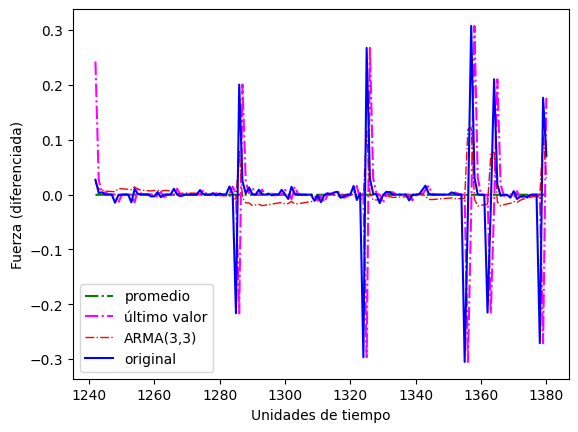

In [ ]:
# Plotting both the curves simultaneously
plt.plot(pred_df['pred_mean'], 'g-.', label='promedio')
plt.plot(pred_df['pred_last_value'], ls='dashdot', c='magenta', label='último valor')
#plt.plot(pred_df['pred_MA'], 'r-.', linewidth=1, label='MA(2)')
#plt.plot(pred_df['pred_AR'], 'r-.', linewidth=1, label='AR(3)')
plt.plot(pred_df['pred_ARMA'], 'r-.', linewidth=1, label='ARMA(3,3)')
plt.plot(pred_df['diff_p1ex'], color='b', label='original')

# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Unidades de tiempo")
plt.ylabel("Fuerza (diferenciada)")

# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

# To load the display window
plt.show()

Ahora vamos a calcular la exactitud de los métodos mediante la métrica MSE

In [ ]:
mse_mean = mean_squared_error(pred_df['diff_p1ex'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['diff_p1ex'], pred_df['pred_last_value'])
#mse_MA = mean_squared_error(pred_df['diff_p1ex'], pred_df['pred_MA'])
#mse_AR = mean_squared_error(pred_df['diff_p1ex'], pred_df['pred_AR'])
mse_ARMA = mean_squared_error(pred_df['diff_p1ex'], pred_df['pred_ARMA'])
print(mse_mean, mse_last, mse_ARMA)

0.004627422174463205 0.011449977672754588 0.0034306052207280224


Ahora vamos a regresar a las unidades originales para comparar la prediccióm de MA(2) con los datos originales

In [ ]:
pred_p1ex = dframe_transposed[8][int(0.9*len(df_diff))] + pred_df['pred_ARMA'].cumsum()

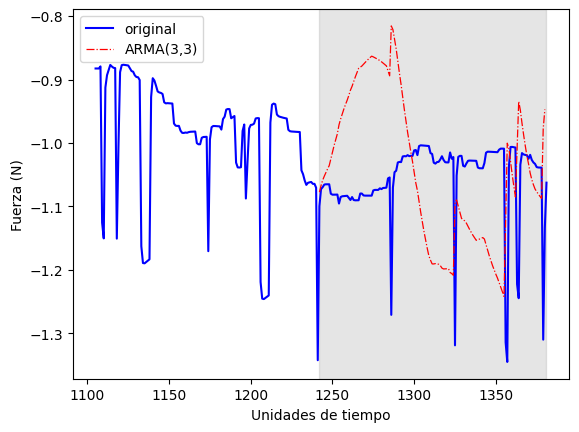

In [ ]:
fig, ax = plt.subplots()

ax.plot(dframe_transposed[8][int(len(dframe_transposed[8])*0.8):], 'b-', label='original')
ax.plot(pred_p1ex, 'r-.', linewidth=0.9, label='ARMA(3,3)')
ax.legend(loc=2)

ax.set_xlabel('Unidades de tiempo')
ax.set_ylabel('Fuerza (N)')

ax.axvspan(int(0.9*len(df_diff)), len(dframe_transposed[8])-1, color='#808080', alpha=0.2)

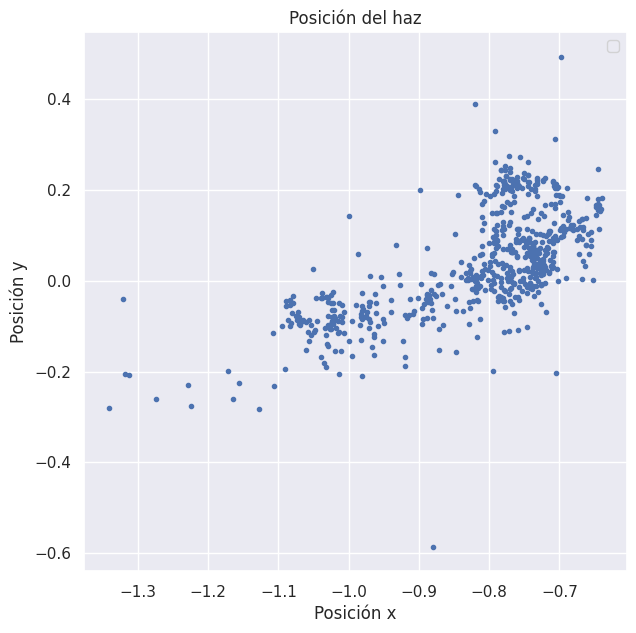

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

plt.figure(figsize=(7, 7))
plt.scatter(p1e_df['p1ex'], p1e_df['p1ey'], marker='.')
# adding title to the plot
plt.title('Posición del haz')

# adding Label to the x-axis
plt.xlabel('Posición x')

# adding Label to the y-axis
plt.ylabel('Posición y')

# adding legend to the curve
plt.legend()
plt.show()

In [ ]:
pos_cluster = p1e_df[['p1ex','p1ey']].to_numpy()

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(pos_cluster)
y_kmeans = kmeans.predict(pos_cluster)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


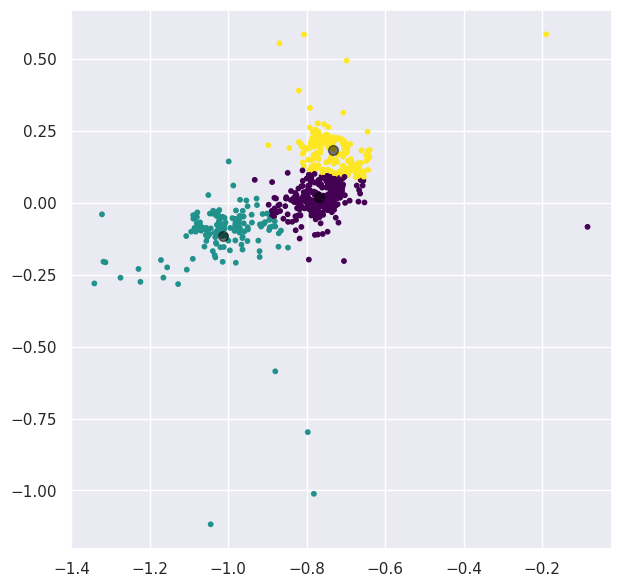

In [ ]:
plt.figure(figsize=(7, 7))
plt.scatter(pos_cluster[:, 0], pos_cluster[:, 1], c=y_kmeans, s=10, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=50, alpha=0.5);